In [1]:
import os
import cv2
import numpy as np
import pickle
from PIL import Image
from sklearn.linear_model import LogisticRegression
from keras_facenet import FaceNet
from mtcnn import MTCNN

In [2]:
dataset = "../data/fsktm"

In [3]:
detector = MTCNN()
embedder = FaceNet()
model = LogisticRegression()

In [4]:
def extractFace(image: Image):

    faces = detector.detect_faces(np.array(image))

    faces = sorted(faces, key=lambda x: x['confidence'], reverse=True)

    try:
        x, y, w, h = faces[0]['box']
    except:
        return image

    return image.crop((x, y, x + w, y + h))

In [5]:
def get_dataset(dtype="train", crop_face=False):
    images = []
    targets = []
    with open(os.path.join(dataset, dtype + '.csv'), 'r') as file:
        for line in file.readlines():
            path, cls = map(lambda x: x.strip(), line.split(','))

            img = extractFace(Image.open(path)) if crop_face else Image.open(path)

            images.append(cv2.resize(np.array(img), (160, 160)))

            targets.append(int(cls))

    # Convert to numpy
    X = np.array(images)
    y = np.array(targets)

    return X, y

In [6]:
def get_label():
    labels = {}

    with open(os.path.join(dataset, 'label.txt')) as file:
        for i, person in enumerate(file.readlines()):
            labels[int(i)] = person.strip()

    return labels

In [7]:
X_train, y_train = get_dataset(dtype="train")
X_test, y_test = get_dataset(dtype="test")
labels = get_label()

In [8]:
print('X_Train data shape=', X_train.shape)
print('X_Test data shape=', X_test.shape)
print('y_Train data shape=', y_train.shape)
print('y_Test data shape=', y_test.shape)

X_Train data shape= (600, 160, 160, 3)
X_Test data shape= (437, 160, 160, 3)
y_Train data shape= (600,)
y_Test data shape= (437,)


In [9]:
X_train = embedder.embeddings(X_train)
X_test = embedder.embeddings(X_test)
print('Train embed shape=', X_train.shape)
print('Test embed shape=', X_test.shape)

14/14 [==============================] - 8s 535ms/step
Train embed shape= (600, 512)
Test embed shape= (437, 512)


In [10]:
model.fit(X_train, y_train)

LogisticRegression()

In [11]:
print(f"Accuracy: {model.score(X_test, y_test)}")

Accuracy: 0.9633867276887872


# Classification Report

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test), target_names = [label.split('-')[0] for label in labels.values()]))

                                            precision    recall  f1-score   support

                  Ahmad Farhan bin Ariffin       1.00      1.00      1.00        25
                                 Chan Joey       1.00      1.00      1.00         9
                             Chong Jia Mun       0.88      1.00      0.93         7
                              Danial Mecja       1.00      1.00      1.00         9
                             Goh Yan Cheng       1.00      1.00      1.00         8
                               Goh Yu Xuan       1.00      1.00      1.00        25
                   Hariharan AL Puspadaran       0.90      0.86      0.88        22
            Jeevan Pillai AL Ramesh Pillai       1.00      1.00      1.00        11
          Khairol Hazeeq Bin Khairol Nizat       1.00      1.00      1.00        32
                  Kheeshyenraaj AL Murugan       0.67      1.00      0.80         6
                              Khor Hui Ron       1.00      0.88      0.93  

# Confusion Matrix

Text(0.5, 1.0, 'Accuracy Score: 0.9633867276887872')

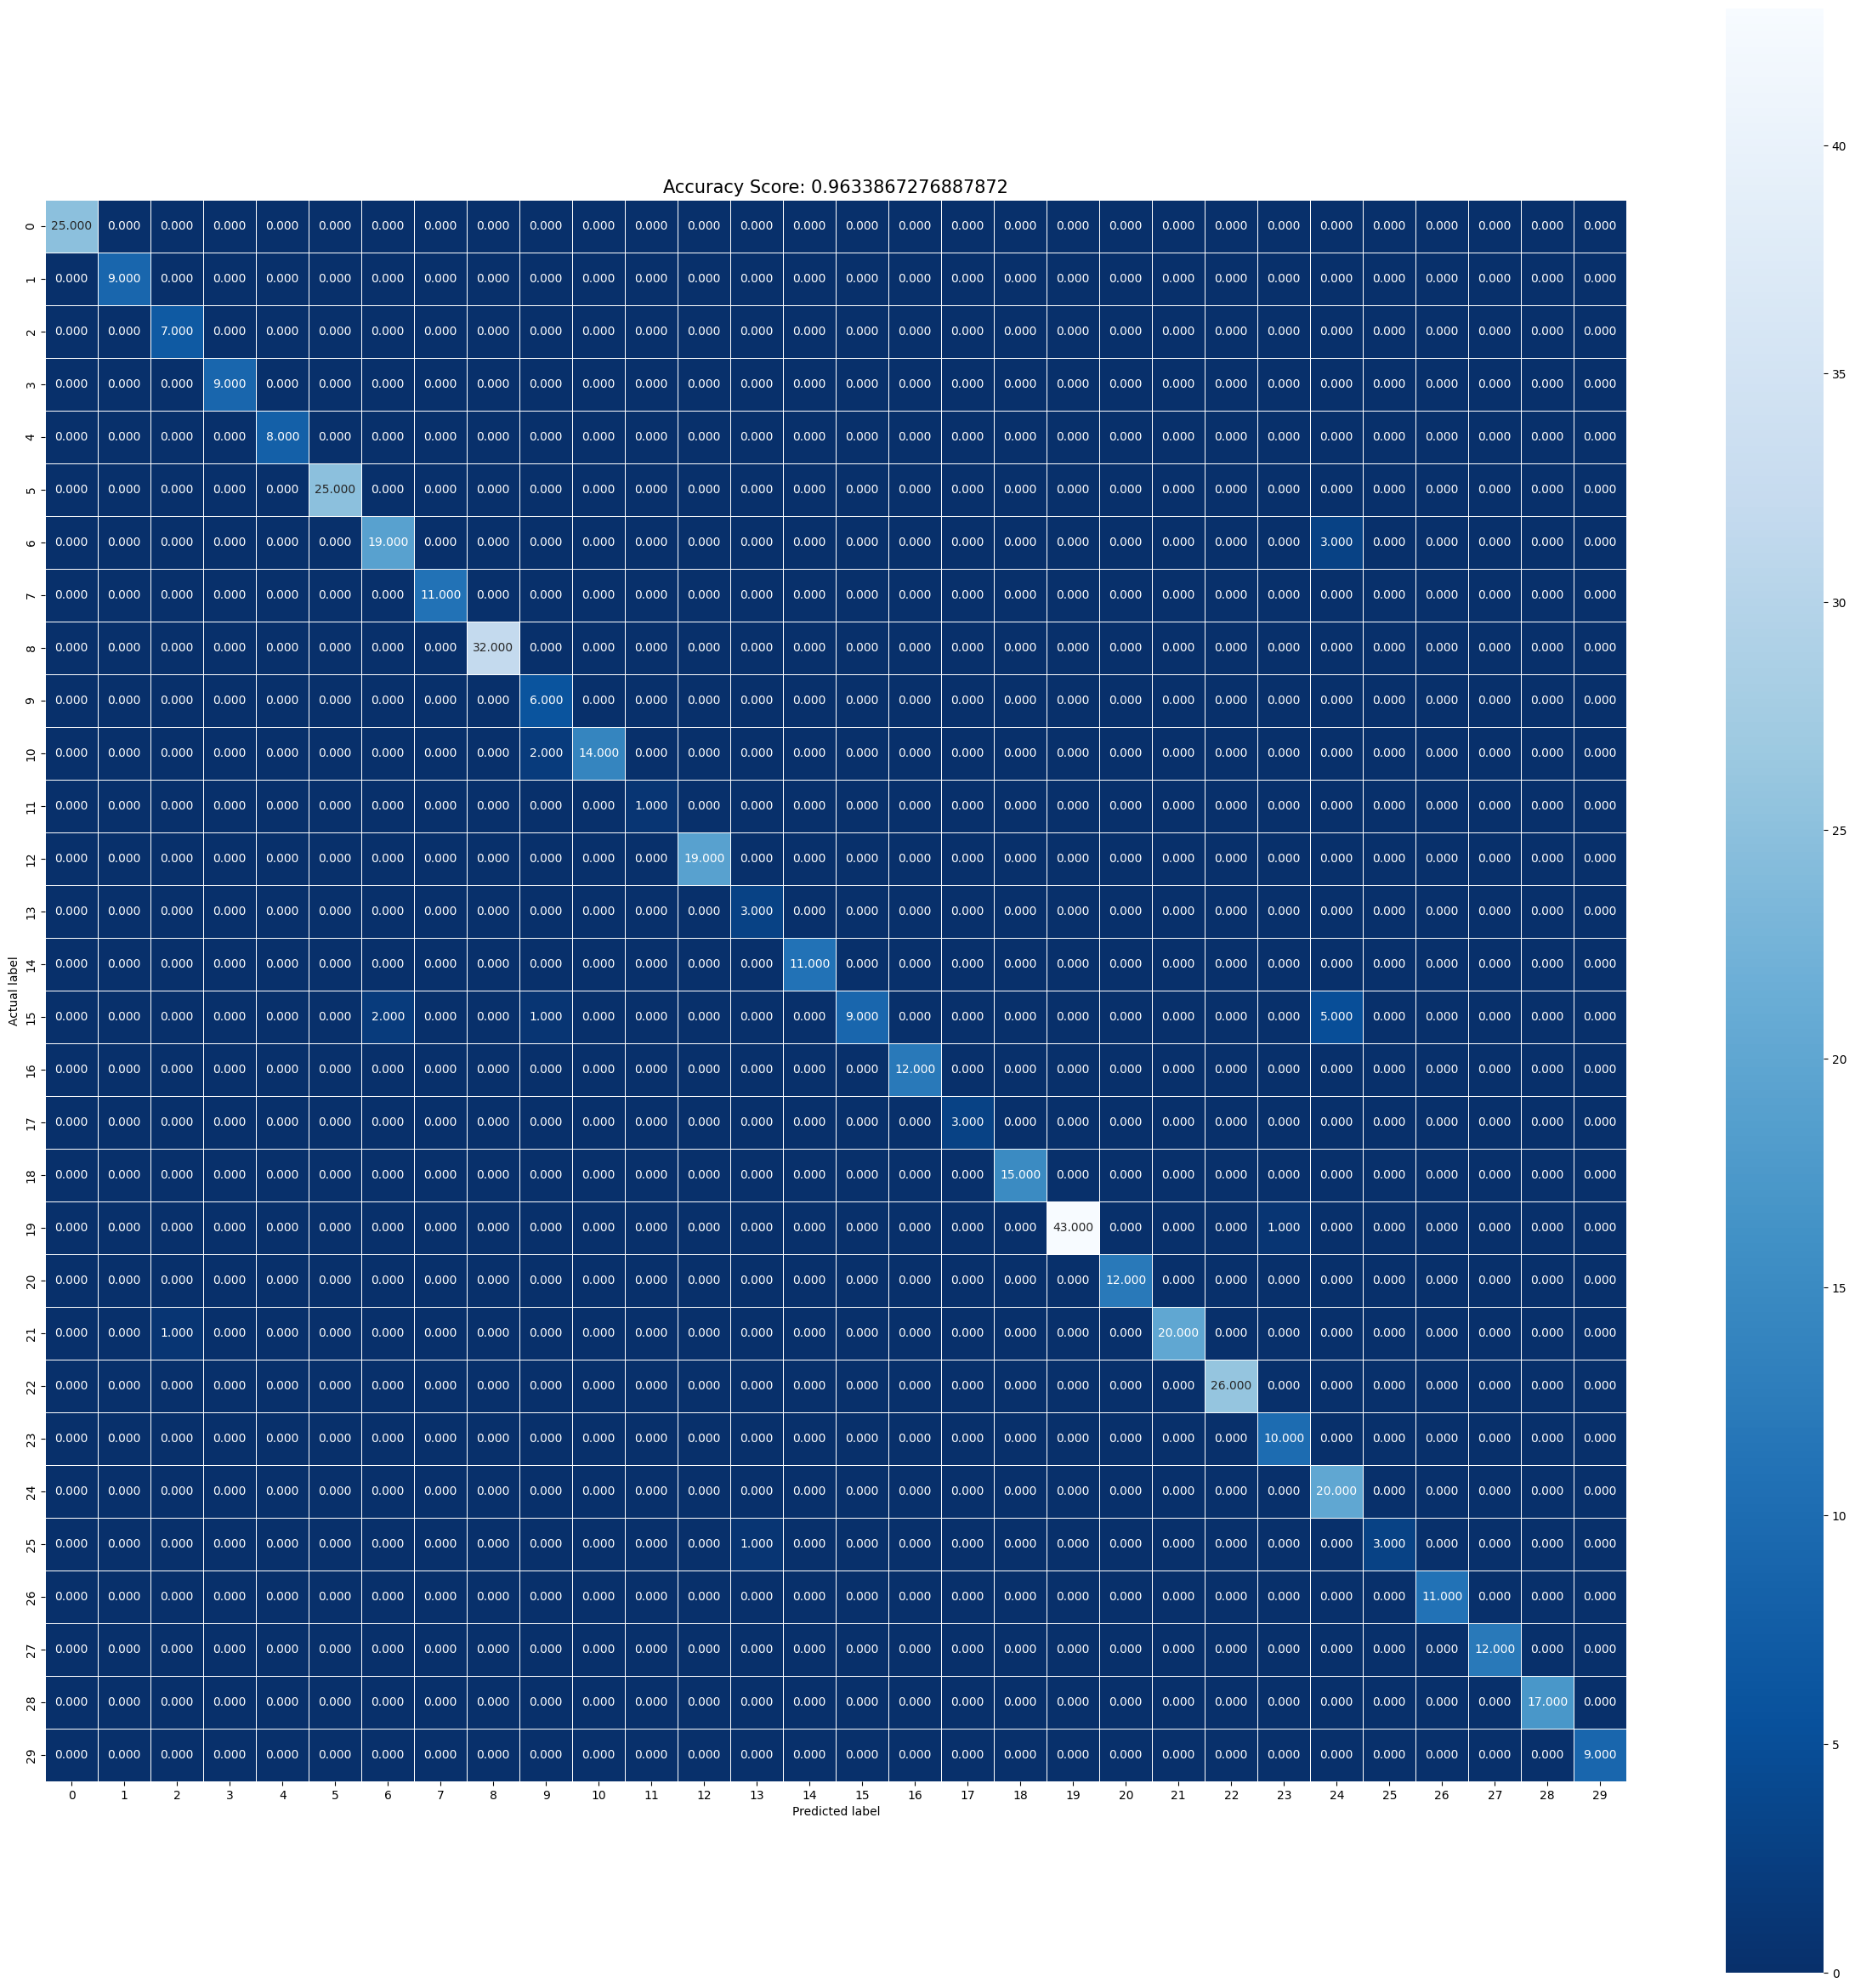

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(30,30))
sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(model.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

# AUC Curve & Score

In [14]:
from sklearn.preprocessing import LabelBinarizer

y_score = model.predict_proba(X_test)
n_classes = len(labels)
target_names = [label.split('-')[0] for label in labels.values()]

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(437, 30)

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay

In [16]:
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [17]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [18]:

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
1.00


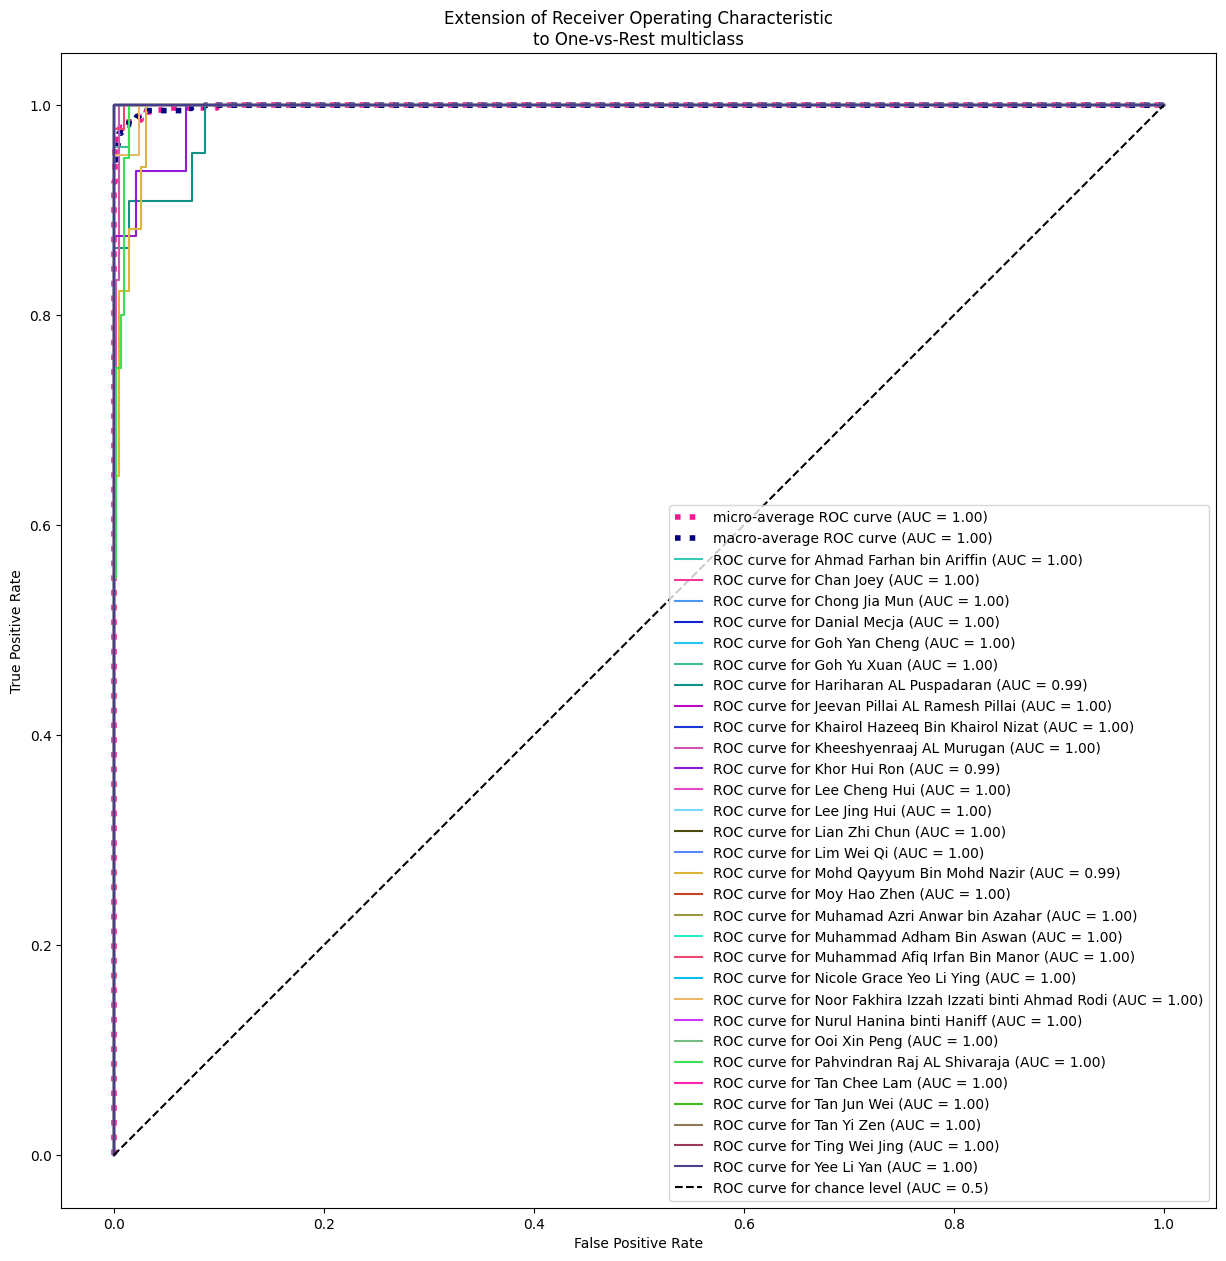

In [19]:
import random

fig, ax = plt.subplots(figsize=(15, 15))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)]) for j in range(n_classes)]
       
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()